# 0816124 林浩君 ML hw2

# import modules

In [15]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import shuffle
from sklearn import tree, metrics, ensemble
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Data input
- 直接讀.csv檔

# 2. Data preprosessing
- 新增grades_bin欄位, 表示學生pass or fail
- 新增grades_5lv欄位, 儲存學生的成績等第(A, B, C, D, F)
- 刪除G3欄位
- 對dataset做shuffle

In [16]:
dataset = pd.read_csv('student-mat.csv', sep=';')
dataset = pd.get_dummies(dataset,drop_first=False)

grades_bin = []
grades_5lv = []
for grade in dataset["G3"]:
    grades_bin.append("pass") if grade >= 10 else grades_bin.append("fail")

upper = [20, 15, 13, 11, 9]
lower = [16, 14, 12, 10, 0]
grades = ['A', 'B', 'C', 'D', 'F']
for grade in dataset["G3"]:
    for i in range(5): 
        if(grade >= lower[i] and grade <= upper[i]): grades_5lv.append(grades[i])

del dataset["G3"]
dataset["grades_bin"] = grades_bin
dataset["grades_5lv"] = grades_5lv
dataset = shuffle(dataset)

display(dataset)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,grades_bin,grades_5lv
257,19,4,3,1,2,0,4,3,1,1,...,0,1,0,1,0,1,1,0,pass,D
328,17,4,4,1,3,0,5,4,4,1,...,0,1,0,1,0,1,1,0,fail,F
138,16,1,1,1,2,1,4,4,4,1,...,0,1,0,1,1,0,0,1,pass,C
343,17,2,2,1,2,1,3,3,1,1,...,0,1,0,1,0,1,0,1,fail,F
340,19,2,1,1,3,1,4,3,4,1,...,0,1,0,1,0,1,0,1,pass,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,18,1,1,2,3,0,5,3,2,1,...,0,1,0,1,0,1,1,0,pass,A
326,17,3,3,1,1,0,4,3,5,3,...,1,0,0,1,0,1,1,0,pass,A
230,17,4,3,1,2,0,3,2,3,1,...,0,1,0,1,0,1,0,1,pass,B
358,18,1,1,2,1,0,3,3,2,1,...,1,0,0,1,0,1,0,1,pass,D


# 3. PCA
- 將以整個feature(沒切training, testing)當作input做pca, 然後印出每個維度variance ratio, 發現前兩個維度就佔了大多數的比例(0.59, 0.22), 並且前十個以後比例佔比都太小, 所以接下來的pca我都會降成10維去做training

# 5. Validation
- 使用sklearn裡的KFold()去做k-fold-validation

In [17]:
features = list(dataset.columns)
features.remove("grades_bin")
features.remove("grades_5lv")

x = dataset[features]
y_bin = dataset["grades_bin"]
y_5lv = dataset["grades_5lv"]

kf = KFold(n_splits=3)
pca = PCA()
pca.fit(x)
print(pca.explained_variance_ratio_.round(2))

[0.59 0.22 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.  ]


# 4. Model Construction
- Decision tree: 使用sklearn裡的tree.DecisionTreeClassifier()
- Random forest: 使用sklearn裡的ensemble.RandomForestClassifier()
- KNN: 使用sklearn裡的KNeighborsClassifier()

# 6. Results
- 對每一個方法, 包含以下資訊
    - confusion matrix
    - classification report
        - precision
        - recall
        - f1-score
    - accuracy

## 6-1. Decision Tree
- Contain below versions with max_leaf_nodes = 20
    - binary without pca
    - 5-level without pca
    - binary with pca(n = 10)
    - 5-level wit pca(n = 10)

In [18]:
def myDecisionTree(x, y, with_pca):
    total_y_test = []
    total_y_pred = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if(with_pca):
            pca = PCA(n_components=10)
            pca.fit(x_train)
            x_train = pca.transform(x_train)
            x_test = pca.transform(x_test)

        clf = tree.DecisionTreeClassifier(max_leaf_nodes=20, random_state=0)
        myclf = clf.fit(x_train, y_train)

        y_pred = myclf.predict(x_test)
        total_y_test += y_test.tolist()
        total_y_pred += y_pred.tolist()
        
    print('\n', (confusion_matrix(total_y_test, total_y_pred)/3).round(2))
    
    matrix = classification_report(total_y_test, total_y_pred, output_dict=True)
    acc = matrix['accuracy']
    del matrix['accuracy']
    for label in matrix:
        matrix[label]['support'] /= 3
    matrix = pd.DataFrame(matrix)
    display(matrix.round(2))
    print('Accuracy: ', acc, '\n')

print("Binary classification without PCA: ")
myDecisionTree(x, y_bin, with_pca=False)
print("5-level classification without PCA: ")
myDecisionTree(x, y_5lv, with_pca=False)
print("Binary classification with PCA: ")
myDecisionTree(x, y_bin, with_pca=True)
print("5-level classification with PCA: ")
myDecisionTree(x, y_5lv, with_pca=True)

Binary classification without PCA: 

 [[34.67  8.67]
 [ 6.33 82.  ]]


,fail,pass,macro avg,weighted avg
precision,0.85,0.90,0.87,0.89
recall,0.80,0.93,0.86,0.89
f1-score,0.82,0.92,0.87,0.89
support,43.33,88.33,131.67,131.67


Accuracy:  0.8860759493670886 

5-level classification without PCA: 

 [[ 9.33  3.67  0.33  0.    0.  ]
 [ 3.   13.33  3.    0.67  0.  ]
 [ 0.    2.   14.    4.67  0.  ]
 [ 0.    0.    8.33 20.33  5.67]
 [ 0.    0.    0.    6.67 36.67]]


,A,B,C,D,F,macro avg,weighted avg
precision,0.76,0.70,0.55,0.63,0.87,0.70,0.72
recall,0.70,0.67,0.68,0.59,0.85,0.70,0.71
f1-score,0.73,0.68,0.60,0.61,0.86,0.70,0.71
support,13.33,20.00,20.67,34.33,43.33,131.67,131.67


Accuracy:  0.7113924050632912 

Binary classification with PCA: 

 [[34.33  9.  ]
 [10.33 78.  ]]


,fail,pass,macro avg,weighted avg
precision,0.77,0.90,0.83,0.85
recall,0.79,0.88,0.84,0.85
f1-score,0.78,0.89,0.84,0.85
support,43.33,88.33,131.67,131.67


Accuracy:  0.8531645569620253 

5-level classification with PCA: 

 [[ 8.67  4.67  0.    0.    0.  ]
 [ 1.67 15.67  2.33  0.33  0.  ]
 [ 0.    5.67 10.67  4.    0.33]
 [ 0.    1.67  5.   17.67 10.  ]
 [ 0.    0.    0.    9.67 33.67]]


,A,B,C,D,F,macro avg,weighted avg
precision,0.84,0.57,0.59,0.56,0.77,0.66,0.66
recall,0.65,0.78,0.52,0.51,0.78,0.65,0.66
f1-score,0.73,0.66,0.55,0.54,0.77,0.65,0.65
support,13.33,20.00,20.67,34.33,43.33,131.67,131.67


Accuracy:  0.6556962025316456 



## 6-2. Random Forest
- Contain below versions with tree_num = 100
    - binary without pca
    - 5-level without pca
    - binary with pca(n = 10)
    - 5-level wit pca(n = 10)
- Compare 3 different numbers of trees
    - 5-level with pca with tree_num = 10
    - 5-level with pca with tree_num = 100
    - 5-level with pca with tree_num = 1000

In [19]:
def myRandomForest(x, y, with_pca, tree_num):
    total_y_test = []
    total_y_pred = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if(with_pca):
            pca = PCA(n_components=10)
            pca.fit(x_train)
            x_train = pca.transform(x_train)
            x_test = pca.transform(x_test)

        forest = ensemble.RandomForestClassifier(n_estimators = tree_num)
        myforest = forest.fit(x_train, y_train)

        y_pred = myforest.predict(x_test)
        total_y_test += y_test.tolist()
        total_y_pred += y_pred.tolist()
    
    print('\n', (confusion_matrix(total_y_test, total_y_pred)/3).round(2))
    
    matrix = classification_report(total_y_test, total_y_pred, output_dict=True)
    acc = matrix['accuracy']
    del matrix['accuracy']
    for label in matrix:
        matrix[label]['support'] /= 3
    matrix = pd.DataFrame(matrix)
    display(matrix.round(2))
    print('Accuracy: ', acc, '\n')

print("Binary classification without PCA: ")
myRandomForest(x, y_bin, with_pca=False, tree_num=100)
print("5-level classification without PCA: ")
myRandomForest(x, y_5lv, with_pca=False, tree_num=100)
print("Binary classification with PCA: ")
myRandomForest(x, y_bin, with_pca=True, tree_num=100)
print("5-level classification with PCA: ")
myRandomForest(x, y_5lv, with_pca=True, tree_num=100)

Binary classification without PCA: 

 [[37.67  5.67]
 [ 5.   83.33]]


,fail,pass,macro avg,weighted avg
precision,0.88,0.94,0.91,0.92
recall,0.87,0.94,0.91,0.92
f1-score,0.88,0.94,0.91,0.92
support,43.33,88.33,131.67,131.67


Accuracy:  0.9189873417721519 

5-level classification without PCA: 

 [[ 8.33  4.67  0.33  0.    0.  ]
 [ 1.67 15.    3.    0.33  0.  ]
 [ 0.    4.33  7.67  8.67  0.  ]
 [ 0.    0.    5.33 19.   10.  ]
 [ 0.    0.    0.    3.67 39.67]]


,A,B,C,D,F,macro avg,weighted avg
precision,0.83,0.62,0.47,0.60,0.80,0.67,0.67
recall,0.62,0.75,0.37,0.55,0.92,0.64,0.68
f1-score,0.71,0.68,0.41,0.58,0.85,0.65,0.67
support,13.33,20.00,20.67,34.33,43.33,131.67,131.67


Accuracy:  0.6810126582278481 

Binary classification with PCA: 

 [[36.67  6.67]
 [ 7.67 80.67]]


,fail,pass,macro avg,weighted avg
precision,0.83,0.92,0.88,0.89
recall,0.85,0.91,0.88,0.89
f1-score,0.84,0.92,0.88,0.89
support,43.33,88.33,131.67,131.67


Accuracy:  0.8911392405063291 

5-level classification with PCA: 

 [[ 9.67  3.33  0.33  0.    0.  ]
 [ 2.   15.    2.67  0.33  0.  ]
 [ 0.33  4.33  9.67  6.33  0.  ]
 [ 0.    0.67  4.67 20.    9.  ]
 [ 0.    0.    0.    5.67 37.67]]


,A,B,C,D,F,macro avg,weighted avg
precision,0.81,0.64,0.56,0.62,0.81,0.69,0.69
recall,0.72,0.75,0.47,0.58,0.87,0.68,0.70
f1-score,0.76,0.69,0.51,0.60,0.84,0.68,0.69
support,13.33,20.00,20.67,34.33,43.33,131.67,131.67


Accuracy:  0.6987341772151898 



In [20]:
print("Random forest with 10 trees:")
myRandomForest(x, y_5lv, with_pca=True, tree_num=10)
print("Random forest with 100 trees:")
myRandomForest(x, y_5lv, with_pca=True, tree_num=100)
print("Random forest with 1000 trees:")
myRandomForest(x, y_5lv, with_pca=True, tree_num=1000)

Random forest with 10 trees:

 [[ 8.    4.    1.    0.33  0.  ]
 [ 4.   12.    2.    2.    0.  ]
 [ 0.33  4.67  7.    7.67  1.  ]
 [ 0.    0.67  4.33 18.33 11.  ]
 [ 0.    0.    0.    6.33 37.  ]]


,A,B,C,D,F,macro avg,weighted avg
precision,0.65,0.56,0.49,0.53,0.76,0.60,0.61
recall,0.60,0.60,0.34,0.53,0.85,0.59,0.63
f1-score,0.62,0.58,0.40,0.53,0.80,0.59,0.62
support,13.33,20.00,20.67,34.33,43.33,131.67,131.67


Accuracy:  0.6253164556962025 

Random forest with 100 trees:

 [[ 9.    4.    0.33  0.    0.  ]
 [ 1.33 15.33  3.    0.33  0.  ]
 [ 0.33  3.67  9.67  7.    0.  ]
 [ 0.    1.    5.   18.   10.33]
 [ 0.    0.    0.    6.33 37.  ]]


,A,B,C,D,F,macro avg,weighted avg
precision,0.84,0.64,0.54,0.57,0.78,0.67,0.67
recall,0.68,0.77,0.47,0.52,0.85,0.66,0.68
f1-score,0.75,0.70,0.50,0.55,0.82,0.66,0.67
support,13.33,20.00,20.67,34.33,43.33,131.67,131.67


Accuracy:  0.6759493670886076 

Random forest with 1000 trees:

 [[ 9.67  3.67  0.    0.    0.  ]
 [ 1.67 16.    2.33  0.    0.  ]
 [ 0.33  3.67 10.    6.67  0.  ]
 [ 0.    0.33  4.   20.33  9.67]
 [ 0.    0.    0.    4.67 38.67]]


,A,B,C,D,F,macro avg,weighted avg
precision,0.83,0.68,0.61,0.64,0.80,0.71,0.71
recall,0.72,0.80,0.48,0.59,0.89,0.70,0.72
f1-score,0.77,0.73,0.54,0.62,0.84,0.70,0.71
support,13.33,20.00,20.67,34.33,43.33,131.67,131.67


Accuracy:  0.7189873417721518 



## 6-3. KNN
- Contain below versions with k = 5
    - binary without pca
    - 5-level without pca
    - binary with pca(n = 10)
    - 5-level wit pca(n = 10)
- Compare 3 different k
    - 5-level with pca with k = 5
    - 5-level with pca with k = 10
    - 5-level with pca with k = 50

In [21]:
def myKNN(x, y, with_pca, k_num):
    total_y_test = []
    total_y_pred = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if(with_pca):
            pca = PCA(n_components=10)
            pca.fit(x_train)
            x_train = pca.transform(x_train)
            x_test = pca.transform(x_test)

        knn = KNeighborsClassifier(n_neighbors=k_num)
        myknn = knn.fit(x_train, y_train)

        y_pred = myknn.predict(x_test)
        total_y_test += y_test.tolist()
        total_y_pred += y_pred.tolist()
    
    print('\n', (confusion_matrix(total_y_test, total_y_pred)/3).round(2))
    
    matrix = classification_report(total_y_test, total_y_pred, output_dict=True)
    acc = matrix['accuracy']
    del matrix['accuracy']
    for label in matrix:
        matrix[label]['support'] /= 3
    matrix = pd.DataFrame(matrix)
    display(matrix.round(2))
    print('Accuracy: ', acc, '\n')
    
print("Binary classification without PCA: ")
myKNN(x, y_bin, with_pca=False, k_num=5)
print("5-level classification without PCA: ")
myKNN(x, y_5lv, with_pca=False, k_num=5)
print("Binary classification with PCA: ")
myKNN(x, y_bin, with_pca=True, k_num=5)
print("5-level classification with PCA: ")
myKNN(x, y_5lv, with_pca=True, k_num=5)

Binary classification without PCA: 

 [[34.67  8.67]
 [ 7.   81.33]]


,fail,pass,macro avg,weighted avg
precision,0.83,0.90,0.87,0.88
recall,0.80,0.92,0.86,0.88
f1-score,0.82,0.91,0.86,0.88
support,43.33,88.33,131.67,131.67


Accuracy:  0.8810126582278481 

5-level classification without PCA: 

 [[ 7.67  5.33  0.33  0.    0.  ]
 [ 2.67 15.33  1.67  0.33  0.  ]
 [ 0.    5.67  8.    7.    0.  ]
 [ 0.    0.67  6.33 20.33  7.  ]
 [ 0.    0.    0.67  8.   34.67]]


,A,B,C,D,F,macro avg,weighted avg
precision,0.74,0.57,0.47,0.57,0.83,0.64,0.66
recall,0.57,0.77,0.39,0.59,0.80,0.62,0.65
f1-score,0.65,0.65,0.42,0.58,0.82,0.62,0.65
support,13.33,20.00,20.67,34.33,43.33,131.67,131.67


Accuracy:  0.6531645569620254 

Binary classification with PCA: 

 [[32.33 11.  ]
 [ 6.   82.33]]


,fail,pass,macro avg,weighted avg
precision,0.84,0.88,0.86,0.87
recall,0.75,0.93,0.84,0.87
f1-score,0.79,0.91,0.85,0.87
support,43.33,88.33,131.67,131.67


Accuracy:  0.8708860759493671 

5-level classification with PCA: 

 [[ 8.    5.    0.33  0.    0.  ]
 [ 2.33 15.33  1.67  0.67  0.  ]
 [ 0.    5.33  7.33  8.    0.  ]
 [ 0.    0.33  7.   21.    6.  ]
 [ 0.    0.    0.33 10.67 32.33]]


,A,B,C,D,F,macro avg,weighted avg
precision,0.77,0.59,0.44,0.52,0.84,0.63,0.65
recall,0.60,0.77,0.35,0.61,0.75,0.62,0.64
f1-score,0.68,0.67,0.39,0.56,0.79,0.62,0.64
support,13.33,20.00,20.67,34.33,43.33,131.67,131.67


Accuracy:  0.6379746835443038 



In [22]:
print("k-nearest-neighbor with k = 5")
myKNN(x, y_5lv, with_pca=True, k_num=5)
print("k-nearest-neighbor with k = 10")
myKNN(x, y_5lv, with_pca=True, k_num=10)
print("k-nearest-neighbor with k = 50")
myKNN(x, y_5lv, with_pca=True, k_num=50)

k-nearest-neighbor with k = 5

 [[ 8.    5.    0.33  0.    0.  ]
 [ 2.33 15.33  1.67  0.67  0.  ]
 [ 0.    5.33  7.33  8.    0.  ]
 [ 0.    0.33  7.   21.    6.  ]
 [ 0.    0.    0.33 10.67 32.33]]


,A,B,C,D,F,macro avg,weighted avg
precision,0.77,0.59,0.44,0.52,0.84,0.63,0.65
recall,0.60,0.77,0.35,0.61,0.75,0.62,0.64
f1-score,0.68,0.67,0.39,0.56,0.79,0.62,0.64
support,13.33,20.00,20.67,34.33,43.33,131.67,131.67


Accuracy:  0.6379746835443038 

k-nearest-neighbor with k = 10

 [[ 8.67  4.    0.67  0.    0.  ]
 [ 1.   16.33  1.33  1.33  0.  ]
 [ 0.    5.    8.    7.67  0.  ]
 [ 0.    0.67  5.   22.33  6.33]
 [ 0.    0.    0.   10.   33.33]]


,A,B,C,D,F,macro avg,weighted avg
precision,0.90,0.63,0.53,0.54,0.84,0.69,0.69
recall,0.65,0.82,0.39,0.65,0.77,0.65,0.67
f1-score,0.75,0.71,0.45,0.59,0.80,0.66,0.67
support,13.33,20.00,20.67,34.33,43.33,131.67,131.67


Accuracy:  0.6734177215189874 

k-nearest-neighbor with k = 50

 [[ 1.33 11.    0.67  0.33  0.  ]
 [ 0.   16.67  2.    1.33  0.  ]
 [ 0.    4.33  2.67 12.67  1.  ]
 [ 0.    0.    2.67 25.67  6.  ]
 [ 0.    0.    0.    9.   34.33]]


,A,B,C,D,F,macro avg,weighted avg
precision,1.00,0.52,0.33,0.52,0.83,0.64,0.64
recall,0.10,0.83,0.13,0.75,0.79,0.52,0.61
f1-score,0.18,0.64,0.19,0.62,0.81,0.49,0.57
support,13.33,20.00,20.67,34.33,43.33,131.67,131.67


Accuracy:  0.6126582278481013 



# 7. Comparison & Conclusion
- 5-level的accuracy平均比binary低, 因為label數增加, 預測的難度也增加
- 有pca的平均比沒有pca的略低一點, 因為pca是將資料做投影壓縮, 但是表現也差不了多少
- 比較不同tree_num的random_forest中, tree_num越多表現越好, 當然跑的也越久
- 比較不同k的KNN中, k=5時是表現最好的, 隨著k變大表現反而會下降, 可能因為k變大時也同時抓到很遠的data, 所以選擇適當的k很重要

# 8. Questions
- Decision Tree
    - Show the prediction and reasoning of one arbitrary sample in the testing set
        - <img src="https://i.imgur.com/0VVjs39.png" style="max-width: 700px;"/>
- Random Forest
    - Describe the difference between boosting and bagging
        - 1. boosting用很多個weak classifier合成一個strong classifier, 而baggin是將很多strong classifier做majority vote
        - 2. Decision Tree做bagging即為Random Forest
- KNN
    - Show the prediction and resoning of one arbitrary sample in the testing set
        - choose k = 5
        - point 1
            - distance: 5.0
            - label:  D
        - point 2
            - distance: 4.795831523312719
            - label:  D
        - point 3
            - distance: 4.898979485566356
            - label:  C
        - point 4
            - distance: 4.69041575982343
            - label:  C
        - point 5
            - distance: 4.795831523312719
            - label:  D
        - predict result:  ['D']
        - 可以看到最近的點的label分別是DDCCD, 所以投票出來的predict result是D
    - Bonus: pick 2 features, draw and describe the KNN decision boundaries
        - <img src="https://i.imgur.com/bvzDTvJ.png" style="max-width: 700px;"/>
- PCA
    - In 5-Level classification, reduce the data dimension to 2 using PCA and draw a scatter plot. You have to colorize the data points based on their labels
        - 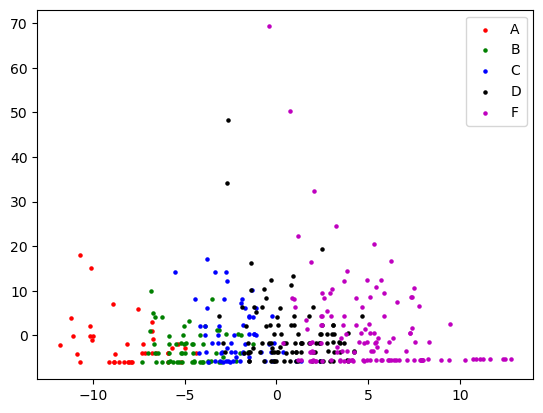

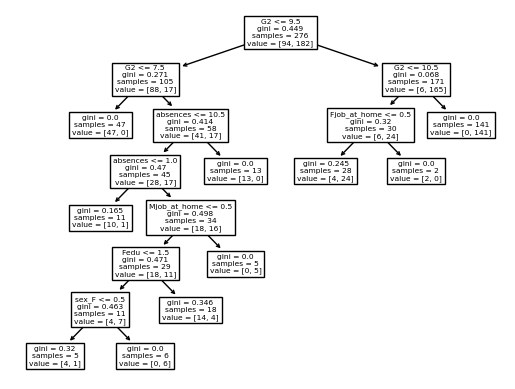

['pass'] ['pass']
[age                  16
Medu                  1
Fedu                  1
traveltime            2
studytime             1
failures              0
famrel                4
freetime              3
goout                 2
Dalc                  1
Walc                  4
health                5
absences              6
G1                    9
G2                    9
school_GP             1
school_MS             0
sex_F                 1
sex_M                 0
address_R             0
address_U             1
famsize_GT3           1
famsize_LE3           0
Pstatus_A             0
Pstatus_T             1
Mjob_at_home          1
Mjob_health           0
Mjob_other            0
Mjob_services         0
Mjob_teacher          0
Fjob_at_home          0
Fjob_health           0
Fjob_other            1
Fjob_services         0
Fjob_teacher          0
reason_course         0
reason_home           1
reason_other          0
reason_reputation     0
guardian_father       0
guardian_mother      

In [23]:
x_train, x_test = x.iloc[:math.floor(len(x)*0.7)], [x.iloc[-1]]
y_train, y_test = y_bin.iloc[:math.floor(len(x)*0.7)], [y_bin.iloc[-1]]

clf = tree.DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)
myclf = clf.fit(x_train, y_train)

tree.plot_tree(myclf, feature_names=features)
plt.show()

y_pred = myclf.predict(x_test)
print(y_test, y_pred)
print(x_test)

In [24]:
x_train, x_test = x.iloc[:math.floor(len(x)*0.7)], [x.iloc[-1]]
y_train, y_test = y_5lv.iloc[:math.floor(len(x)*0.7)], [y_5lv.iloc[-1]]

knn = KNeighborsClassifier(n_neighbors=5)
myknn = knn.fit(x_train, y_train)
y_pred = myknn.predict(x_test)

distance = []
for data in x_train.iloc:
    distance.append(-np.linalg.norm(np.array(x_test[0]) - np.array(data)))
indices = np.argpartition(distance, -5)[-5:]

for i, index in enumerate(indices):
    print("point", i+1)
    print("distance:", -distance[index])
    print("label: ", y_train.iloc[index])
    print()
    
print("predict result: ", y_pred)

point 1
distance: 5.830951894845301
label:  D

point 2
distance: 5.744562646538029
label:  D

point 3
distance: 5.656854249492381
label:  D

point 4
distance: 5.291502622129181
label:  D

point 5
distance: 5.196152422706632
label:  D

predict result:  ['D']


<ipython-input-25-9e73329516ca>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz, cmap=cmap_light, alpha=0.7)


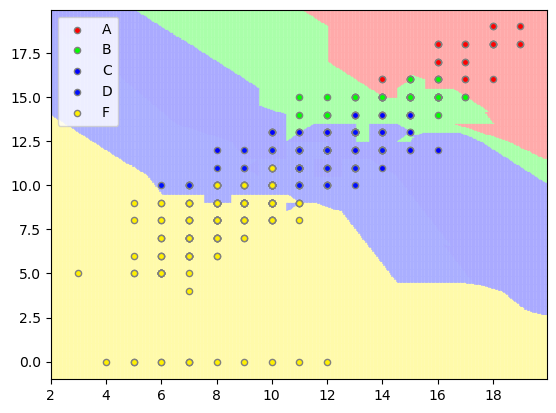

In [25]:
x_knn = np.array(x[['G1', 'G2']])
y_knn = pd.Series(y_5lv.tolist())

knn = KNeighborsClassifier(n_neighbors=5)
myknn = knn.fit(x_knn, y_knn)

grades = {'A':0, 'B':1, 'C':2, 'D':3, 'F':4}
cmap_light = colors.ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#AAAFFF', '#FFFAAA'])
cmap_bold =['#FF0000', '#00FF00', '#0000FF', '#000FFF', '#FFF000']

plt.figure()
xx, yy = np.meshgrid(np.arange(2, 20, 0.05), np.arange(-1, 20, 0.05))
zz = knn.predict(np.c_[xx.ravel(), yy.ravel()])
for i in range(len(zz)):
    zz[i] = grades[zz[i]]
zz = zz.reshape(xx.shape)
zz = zz.astype(np.int32)
plt.pcolormesh(xx, yy, zz, cmap=cmap_light, alpha=0.7)
ls = []
for grade in grades:
    indices = y_knn[y_knn == grade].index
    l = plt.scatter(x_knn[indices, 0], x_knn[indices, 1], color=cmap_bold[grades[grade]], s=20, edgecolors='gray')
    ls.append(l)
plt.legend(handles=ls, labels=grades, loc="best")
plt.show()

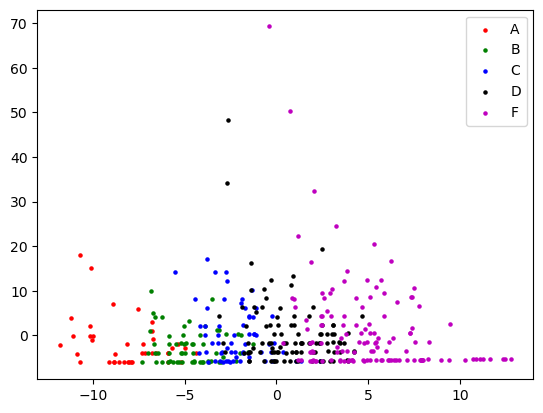

In [26]:
pca = PCA(n_components=2)
pca.fit(x)
x_pca = pca.transform(x)
y_pca = pd.Series(y_5lv.tolist())

ls = []
grades = ['A', 'B', 'C', 'D', 'F']
colors = {'A':'r', 'B':'g', 'C':'b', 'D':'k', 'F':'m'}

plt.figure()
for grade in grades:
    indices = y_pca[y_pca == grade].index
    l = plt.scatter(x_pca[indices, 1], x_pca[indices, 0], color=colors[grade], s=5)
    ls.append(l)
plt.legend(handles=ls, labels=grades, loc="best")
plt.show()